# Applied Predictive Modeling with R

In [1]:
# find functions for creating confusion matrix within the currenltly loaded packages
print(apropos("confusion"))

# Find such a function in any package. Opens a new browser window
#RSiteSearch("confusion", restrict = "functions")

character(0)


### Install AppliedPredictiveModeling package

In [2]:
#install.packages(c('AppliedPredictiveModeling'))

### Load Applied Predictive Modeling Package

In [3]:
library(AppliedPredictiveModeling)

Load the data into R

In [4]:
data(segmentationOriginal)
segData <- subset(segmentationOriginal, Case == "Train")

Save Class and Cell fields into separate vectors and then remove them from the main object

In [5]:
cellId <- segData$Cell
class <- segData$Class
case <- segData$Case

# Now remove the columns
segData <- segData[,-(1:3)]

The original data contained several "status" columns which were binary versions of the predictors.
To remove these, we find the column names containing "Status" and remove them

In [6]:
statusColNum <- grep("Status", names(segData))
statusColNum

[1]   2   4   9  10  11  12  14  16  20  21  22  26  27  28  30  32  34  36  38
[20]  40  43  44  46  48  51  52  55  56  59  60  63  64  68  69  70  72  73  74
[39]  76  78  80  82  84  86  88  92  93  94  97  98 103 104 105 106 110 111 112
[58] 114

In [7]:
segData <- segData[,-statusColNum]

## **Transformations**

#### Skewness
The e1071 package calculates the sample skewness statistic for each predictor

In [8]:
library(e1071)

#For one predictor:
skewness(segData$AngleCh1)

# Since all predictors are numeric columns, the apply function can 
# be used to computre skewness accross columns
# apply(data, 1=Col, 2=Rows, c(1,2) = Row and Col, function)
skewValues <- apply(segData, 2, skewness)
head(skewValues)

[1] -0.02426252

AngleCh1     AreaCh1 AvgIntenCh1 AvgIntenCh2 AvgIntenCh3 AvgIntenCh4 
-0.02426252  3.52510745  2.95918524  0.84816033  2.20234214  1.90047128

Asses shape of distribution

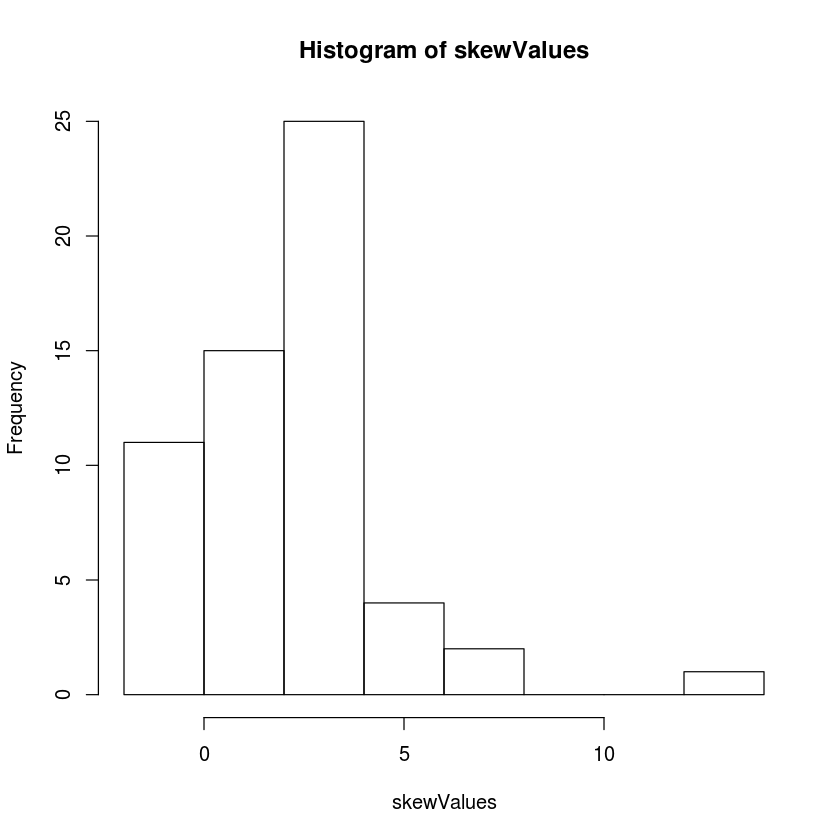

In [9]:
hist(skewValues)

Use boxcox contained in the MASS package to determine which type of transformation we should use

In [10]:
library(caret)
Ch1AreaTrans <- BoxCoxTrans(segData$AreaCh1)
Ch1AreaTrans

Loading required package: lattice
Loading required package: ggplot2


Box-Cox Transformation

1009 data points used to estimate Lambda

Input data summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  150.0   194.0   256.0   325.1   376.0  2186.0 

Largest/Smallest: 14.6 
Sample Skewness: 3.53 

Estimated Lambda: -0.9 


**Original Data**

In [11]:
head(segData$AreaCh1)

[1] 819 431 298 256 258 358

**After Transformation**

In [12]:
predict(Ch1AreaTrans, head(segData$AreaCh1))

[1] 1.108458 1.106383 1.104520 1.103554 1.103607 1.105523

In [13]:
# Compute manually
(819^(-.9)-1)/(-.9)

[1] 1.108458

Another caret function preProcess, applies this transformation to a set of predictors.

Base R function prcomp can be used for PCA. Data below is centered and scaled prior to PCA

In [14]:
pcaObject <- prcomp(segData, center = TRUE, scale. = TRUE)

# Calculate the cumulative percentage of variance which each component accounts for
percentVariance <- pcaObject$sd^2/sum(pcaObject$sd^2)*100
percentVariance[1:3]

[1] 20.91236 17.01330 11.88689

The transformed values are stored in pcaObject as a sub-object called x:

In [15]:
head(pcaObject$x[,1:5])

,PC1,PC2,PC3,PC4,PC5
2,5.0985749,4.5513804,-0.03345155,-2.640339,1.2783212
3,-0.2546261,1.1980326,-1.02059569,-3.731079,0.9994635
4,1.2928941,-1.8639348,-1.25110461,-2.414857,-1.4914838
12,-1.4646613,-1.5658327,0.46962088,-3.388716,-0.3302324
15,-0.8762771,-1.2790055,-1.33794261,-3.516794,0.3936099
16,-0.8615416,-0.3286842,-0.15546723,-2.206636,1.4731658


The other sub-object called rotation stores the variable loadings, where rows correspond to predictor variables and columns are associated with the components

In [16]:
head(pcaObject$rotation[,1:3])

,PC1,PC2,PC3
AngleCh1,0.001213758,-0.01284461,0.006816473
AreaCh1,0.229171873,0.16061734,0.089811727
AvgIntenCh1,-0.102708778,0.17971332,0.067696745
AvgIntenCh2,-0.154828672,0.16376018,0.073534399
AvgIntenCh3,-0.058042158,0.11197704,-0.185473286
AvgIntenCh4,-0.117343465,0.21039086,-0.105060977


The caret package also contains spatialSign package for spatial sign transformation.

The syntax to use this transformation is 
```python
spatialSign(segData)
```

This data does not have missing values. However, the `impute` package has a function, `impute.knn`, that uses K-nearest neighbors to estimate the missing data. The previously mentions `preProcess` function applies the imputation methods using K-nearest neighbors or bagged trees.

To administer a series of transformation to multiple data sets, the caret class `preProcess` has the ability to transform, center, scale, or impute values, as well as apply the spatial sign transformation and feature extraction. After calling the `preProcess` function, the `predict` method applies the results to a set of data

The order in which transformations are applied is:
1. transformation
2. centering
3. scaling
4. imputation
5. feature extraction
6. spatial sign

### **preProcess**

In [17]:
trans <- preProcess(segData,
                    method = c("BoxCox", "center", "scale", "pca"))
trans

Created from 1009 samples and 58 variables

Pre-processing:
  - Box-Cox transformation (47)
  - centered (58)
  - ignored (0)
  - principal component signal extraction (58)
  - scaled (58)

Lambda estimates for Box-Cox transformation:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.00000 -0.50000 -0.10000  0.05106  0.30000  2.00000 

PCA needed 19 components to capture 95 percent of the variance

### **apply transformations**

In [18]:
transformed <- predict(trans, segData)

# These values are different than the previous PCA components since
# they were transformed prior to PCA
head(transformed[,1:5])

,PC1,PC2,PC3,PC4,PC5
2,1.5684742,6.2907855,-0.3333299,-3.063327,-1.3415782
3,-0.6664055,2.0455375,-1.4416841,-4.701183,-1.7422020
4,3.7500055,-0.3915610,-0.6690260,-4.020753,1.7927777
12,0.3768509,-2.1897554,1.4380167,-5.327116,-0.4066757
15,1.0644951,-1.4646516,-0.9900478,-5.627351,-0.8650174
16,-0.3798629,0.2173028,0.4387980,-2.069880,-1.9363920


### Filtering

To filter near-zero variance predictors, the `caret` package function `nearZeroVar` will return the column numbers of any predictors that don't explain the variance in the data.

When a vector should be removed, a vector of integers is returned that indicates which columns should be removed

In [19]:
# For this dataset there are no nearZeroVar predictors.

nearZeroVar(segData)

integer(0)

Similarly, to filter on between-predictor correlations, the cor function can calculate the correlations between predictor variables

In [20]:
correlations <- cor(segData)
dim(correlations)

[1] 58 58

In [21]:
correlations[1:4, 1:4]

,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2
AngleCh1,1.000000000,-0.002627172,-0.04300776,-0.01944681
AreaCh1,-0.002627172,1.000000000,-0.02529739,-0.15330301
AvgIntenCh1,-0.043007757,-0.025297394,1.00000000,0.52521711
AvgIntenCh2,-0.019446810,-0.153303007,0.52521711,1.00000000


To visualize the correlation data structure use `corrplot` package

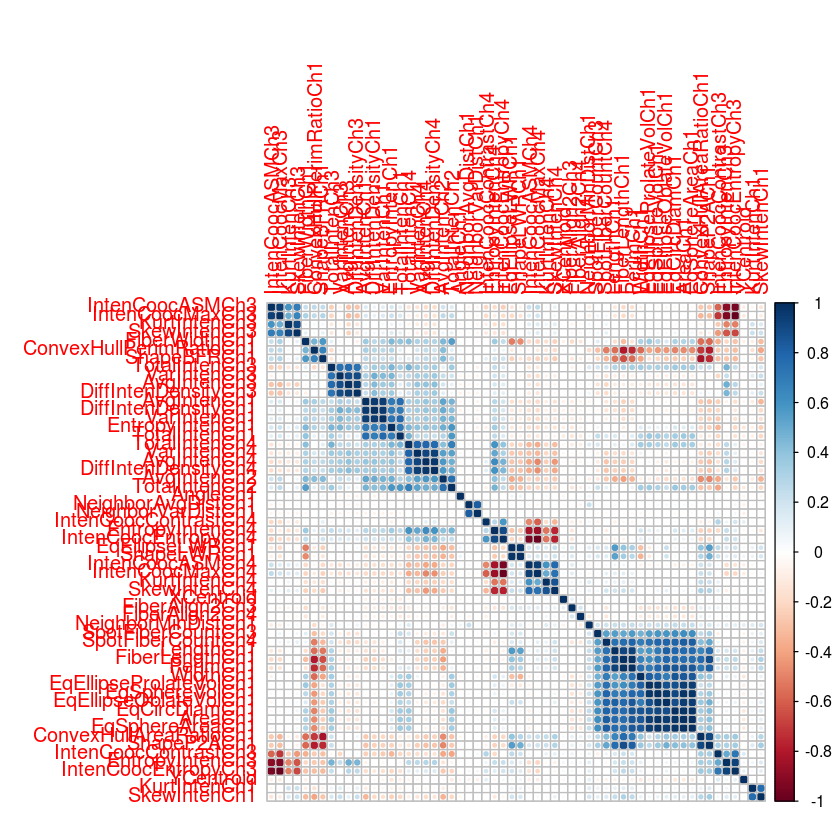

In [22]:
library(corrplot)
corrplot(correlations, order="hclust")

The size and color of the points are associated with the strength of the correlation between two predictor variables

To filter based on correlations, teh findCorrelation function will apply an algorithm for removing predictors.

For a given threshold of pairwise correlations, the function returns the column numbers denoting the predictors that are recommended for deletion:

In [23]:
highCorr <- findCorrelation(correlations, cutoff = .75)
length(highCorr)

[1] 32

In [24]:
head(highCorr)

[1] 23 40 43 36  7 15

In [25]:
filteredSegData <- segData[,-highCorr]

> **Tip:** The `subselect` package has many functions that can also accomplish the same goal

### Creating Dummy Varialbes

There are occasions when a complete set of dummy variables is useful. For instance, the splits in a tree-based model are more interpretable when the dummy variable encode all the information for that predictor.

>**Tip** Use a full set of dummy variables when working with tree-based models

In the example below, we are using the card dataset in the caret library to predict the price of the car based on known characteristics

In [32]:
data(cars)
type <- c("convertible", "coupe", "hatchback", "sedan", "wagon")
cars$Type <- factor(apply(cars[, 14:18], 1, function(x) type[which(x == 1)]))

carSubset <- cars[sample(1:nrow(cars), 20), c(1, 2, 19)]
head(carSubset)
levels(carSubset$Type)

,Price,Mileage,Type
465,13994.91,17270,sedan
216,32075.98,23553,convertible
8,30251.02,27558,convertible
528,21536.74,37128,sedan
301,18527.21,19874,sedan
573,27703.20,24738,sedan


[1] "convertible" "coupe"       "hatchback"   "sedan"       "wagon"

To model the price as a funciton of mileage and type of car, we can use the function dummyVars to determine encodings for the predictors. Suppose our first model assumes that the price can be modeled as a simple additive function of the mileage and type

In [33]:
simpleMod <- dummyVars(~Mileage + Type,
                      data = carSubset,
                      ## Remove the variable name from the column name
                      levelsOnly = TRUE)
simpleMod

Dummy Variable Object

Formula: ~Mileage + Type
2 variables, 1 factors
Factor variable names will be removed
A less than full rank encoding is used

To generate the dummy variables for the training set or any new samples the `predict` method is used in conjuction with the dummyVars object

In [34]:
predict(simpleMod, head(carSubset))

,Mileage,convertible,coupe,hatchback,sedan,wagon
465,17270,0,0,0,1,0
216,23553,1,0,0,0,0
8,27558,1,0,0,0,0
528,37128,0,0,0,1,0
301,19874,0,0,0,1,0
573,24738,0,0,0,1,0


To fit a more advanced model, we could assume that there is a joint effect of mileage and car type. This type of effect is referred to as an interaction. In the model formula, a colon between factors indicates that an interaction should be generated.

In [36]:
withInteraction <- dummyVars(~Mileage + Type + Mileage:Type,
                            data=carSubset,
                            levelsOnly = TRUE)
withInteraction

Dummy Variable Object

Formula: ~Mileage + Type + Mileage:Type
2 variables, 1 factors
Factor variable names will be removed
A less than full rank encoding is used

In [38]:
predict(withInteraction, head(carSubset))

,Mileage,convertible,coupe,hatchback,sedan,wagon,Mileage:convertible,Mileage:coupe,Mileage:hatchback,Mileage:sedan,Mileage:wagon
465,17270,0,0,0,1,0,0,0,0,17270,0
216,23553,1,0,0,0,0,23553,0,0,0,0
8,27558,1,0,0,0,0,27558,0,0,0,0
528,37128,0,0,0,1,0,0,0,0,37128,0
301,19874,0,0,0,1,0,0,0,0,19874,0
573,24738,0,0,0,1,0,0,0,0,24738,0
